# Mushrooms Classification - CNN

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !cp -r "/content/drive/MyDrive/Mushrooms" "/content/"

### Dataset Class

In [4]:
data_dir = 'Mushrooms'

class SafeImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []
        self.class_to_idx = {}

        class_idx = 0
        paths = []
        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            if class_name not in self.class_to_idx:
                self.class_to_idx[class_name] = class_idx
                self.classes.append(class_name)
                class_idx += 1
            for img_name in os.listdir(class_path):
                paths.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))

        corrupted = 0
        for path, label in paths:
            try:
                img = Image.open(path).convert('RGB')
                img.verify()
                img = img.resize((128, 128))
                self.images.append(img)
                self.labels.append(label)
            except Exception:
                corrupted += 1
                print(f"Пропущено: {path}")

        print(f"Загружено изображений: {len(self.images)} | Пропущено повреждённых: {corrupted}")

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

### Data Transforms

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Train/Validation Split

In [6]:
dataset = SafeImageFolder(data_dir, transform=val_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")

Загружено изображений: 6714 | Пропущено повреждённых: 0
Train: 5371 | Val: 1343


### DataLoaders

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

### Архитектура модели

In [ ]:
class MushroomNet(nn.Module):
    def __init__(self, num_classes=9):
        super(MushroomNet, self).__init__()

        self.features = nn.Sequential(
            # Блок 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64x64

            # Блок 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32x32

            # Блок 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            # Блок 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MushroomNet(num_classes=9).to(device)

print(f"Using device: {device}\n")
print(model)
print(f"\nВсего параметров: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda

MushroomNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

### Обучение модели

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=8, factor=0.5)

train_losses = []
test_accuracies = []
epochs = 100

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    batch_count = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        batch_count += 1

    avg_train_loss = total_train_loss / batch_count
    train_losses.append(avg_train_loss)

    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            predicted = torch.argmax(outputs, dim=1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    test_accuracies.append(accuracy)

    scheduler.step(accuracy)

    if epoch % 10 == 0 or epoch == epochs - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d}: Train Loss = {avg_train_loss:.4f}, Test Accuracy = {accuracy:.4f}, LR = {current_lr:.2e}")

print(f"\nФинальная точность: {test_accuracies[-1]:.4f}")

Epoch   0: Train Loss = 1.9990, Test Accuracy = 0.1512, LR = 1.00e-03
Epoch  10: Train Loss = 1.2929, Test Accuracy = 0.3582, LR = 1.00e-03
Epoch  20: Train Loss = 1.0183, Test Accuracy = 0.4125, LR = 1.00e-03
Epoch  30: Train Loss = 0.8194, Test Accuracy = 0.4847, LR = 1.00e-03
Epoch  40: Train Loss = 0.5686, Test Accuracy = 0.6061, LR = 5.00e-04
Epoch  50: Train Loss = 0.4082, Test Accuracy = 0.7014, LR = 2.50e-04
Epoch  60: Train Loss = 0.3532, Test Accuracy = 0.6962, LR = 2.50e-04
Epoch  70: Train Loss = 0.2941, Test Accuracy = 0.7074, LR = 2.50e-04
Epoch  80: Train Loss = 0.2511, Test Accuracy = 0.7133, LR = 1.25e-04
Epoch  90: Train Loss = 0.2088, Test Accuracy = 0.7513, LR = 1.25e-04
Epoch  99: Train Loss = 0.1962, Test Accuracy = 0.7550, LR = 1.25e-04

Финальная точность: 0.7550


### Визуализация результатов

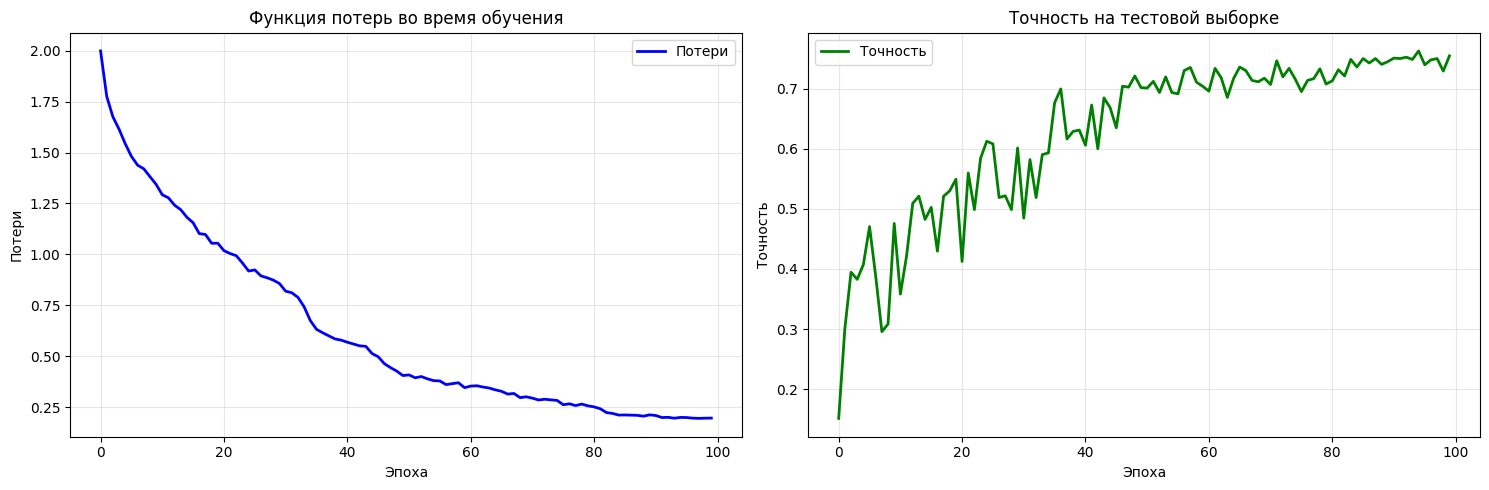

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График функции потерь
ax1.plot(train_losses, 'b-', linewidth=2, label='Потери')
ax1.set_title('Функция потерь во время обучения')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Потери')
ax1.grid(True, alpha=0.3)
ax1.legend()

# График точности
ax2.plot(test_accuracies, 'g-', linewidth=2, label='Точность')
ax2.set_title('Точность на тестовой выборке')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Точность')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()